# BF550 Fall 2022 Lab 8: Differential expression
A common task in bioinformatics is to assess the affect of some treatment by quantifying *differential expression*, or how the expression of some features differ between subjects of the treatment and control groups. These statistics are typically calculated on large datasets. Here we will explore how to handle these calculations seemlessly using Pandas' `groupby()` function to easily calculate differential expression betwee control and treatment for each group of genes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sps

# Problem 1: Building intuition for p-values
Calculate p-values as data is sampled from two distributions that are nearing one another.

**Tasks**: 
1. X: Generate 25 samples from a normal distribution with $\mu=0\text{ and }\sigma=1$
2. Y: Generate 25 samples from another normal distribution with $\mu=4\text{ and }\sigma=1$
3. In one figure, plot these two distributions with transparency in order to see overlapping bins. For ease of visibility, use 10 bins that range from the minimum value to the maximum value over all 50 samples (the bins for the two distributions should overlap).
4. Use a t-test (`sps.ttest_rel()`) to test the hypothesis: X < Y
5. Make the title of the figure the resulting p-value (formatted in scientific notation with 2 digits after the decimal point)
6. Repeat steps 2-5 with $Y_\mu \in \{3, 2, 1, 0\}$ with a different figure for each comparison.
7. Make a figure with properly labeled axes that shows the $Y_\mu-X_\mu$ on the x-axis and the corresponding p-value on a log scaled y-axis.

In [2]:
"T-test on nearing distributions"
n_samples = 25
# X: Generate 25 samples from a normal distribution with  𝜇=0 and 𝜎=1
x = None

# Means for each Y
y_means = []

# A list to save each p-value to
ps = []

In [3]:
"Direct relationship between means and p-values"

'Direct relationship between means and p-values'

# Answer

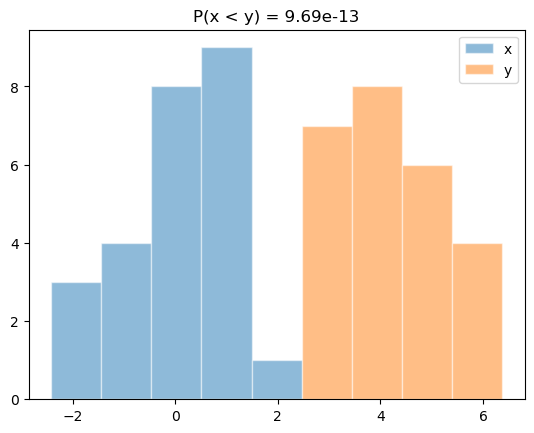

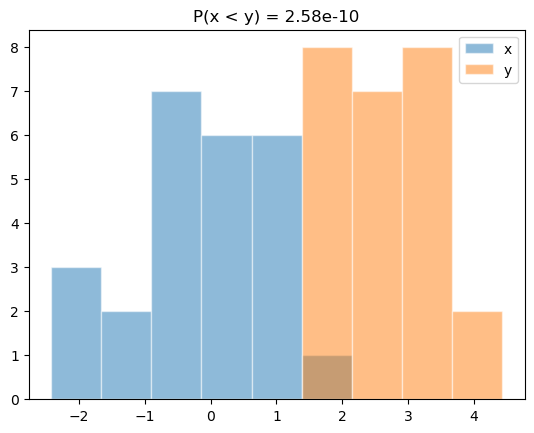

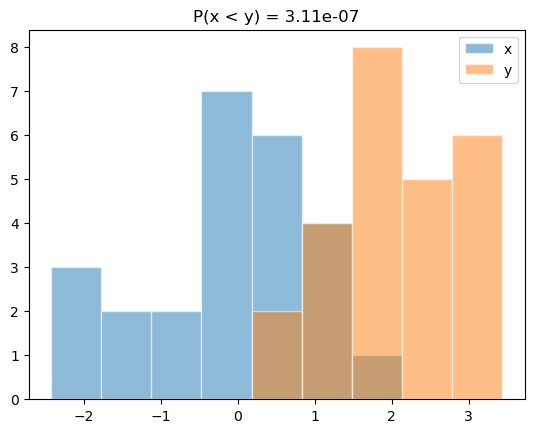

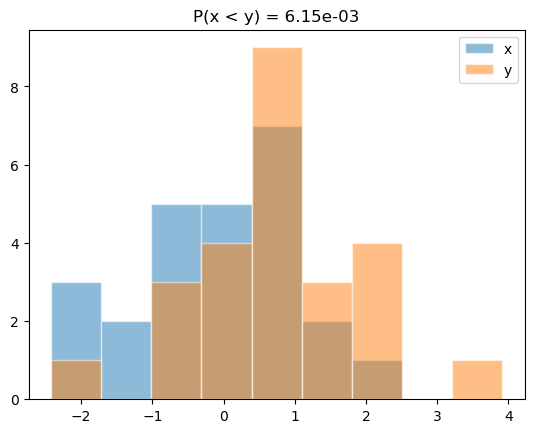

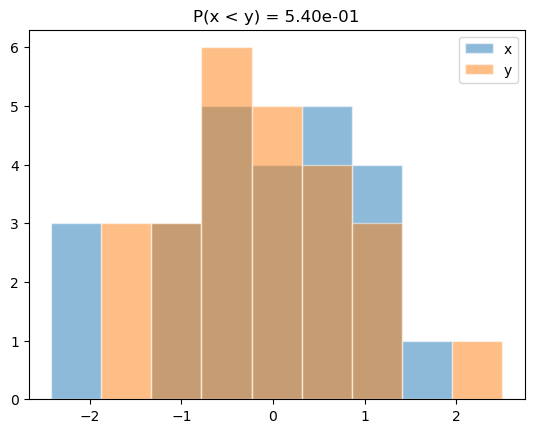

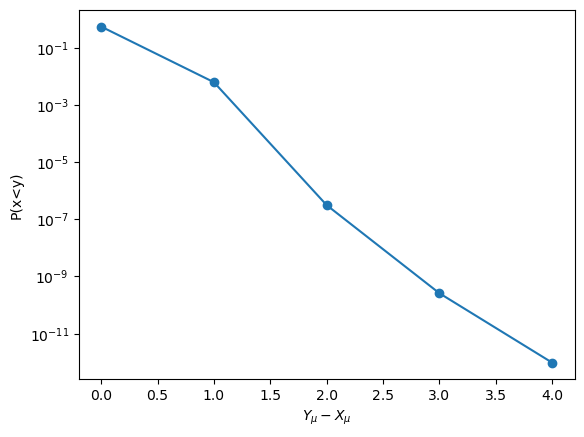

In [4]:
"T-test on nearing distributions"
# Sample from one distribution 
n_samples = 25
x = np.random.normal(size=n_samples)

means = [4, 3, 2, 1, 0]
ps = []

for mean in means:
    # Sample from another distribution
    y = np.random.normal(mean, size=n_samples)
    
    # Get min and max for bin sizes
    all_data = np.array([x, y])
    bins = np.linspace(all_data.min(), all_data.max(), 10)
    
    # Calculate p-value from t-test: P(X<Y)
    p = sps.ttest_rel(x, y, alternative='less').pvalue
    ps.append(p)
    
    kwargs = {'alpha': .5, 'bins': bins, 'ec': 'w'}
    
    # Plot distributions
    plt.hist(x, label='x', **kwargs)
    plt.hist(y, label='y', **kwargs)
    plt.title(f'P(x < y) = {p:.2e}')
    plt.legend()
    plt.show()
    
"Direct relationship between means and p-values"
plt.plot(means, ps, marker='o')
plt.xlabel(r'$Y_\mu-X_\mu$')
plt.ylabel('P(x<y)')
plt.yscale('log')
plt.show()

# Gene expression data
The remainder of the lab will involve using the synthetic dataset generated in the following cell. You can imagine this dataset describing the expression of 1000 genes in 28 subjects - 13 who received some treatment and 15 who did not (control) - measured through transcriptomics sequencing. Your tasks with this dataset will involve investigating the effect of the treatment by finding which genes are **differentially expressed**.

Run this cell to generate the `gene_df`, the dataset of the expression of each gene for each subject.

In [7]:
"Priors for genes"
n_genes = 1000
gene_names = [f'G_{g}' for g in range(n_genes)]

# Random seed for reproducibility
np.random.seed(123) 
# Sample prior probabilities of each gene from a Dirichlet distribution
alpha = np.ones(n_genes)/2
priors_control = np.random.dirichlet(alpha)

# Choose genes to be differentially expressed in treatment
de_genes = np.random.choice(range(n_genes), 20)
alpha[de_genes] = 1/1.5
np.random.seed(123) 
priors_treatment = np.random.dirichlet(alpha)

"Priors for biological samples"
n_control = 15
n_treatment = 13
n_samples = n_treatment + n_control
sample_names = [f'{condition}_{i}' for condition, size in zip(['control', 'treatment'], [n_control, n_treatment]) for i in range(size)]

# Random sequencing depth for each sample
seq_depths = np.random.normal(1e4, 4e3, n_samples).astype(int)

"Generate gene count data"
count_data = []
# Generate count data samples, drawing from Dirichlets for control or treatment
priors = priors_control
for i, depth in enumerate(seq_depths):
    # After generating data for controls, start generating data for treatments
    if i == n_control:
        priors = priors_treatment
    # Sample gene counts 
    sample_counts = np.random.multinomial(depth, priors)
    # Save
    count_data.append(sample_counts)

gene_df = pd.DataFrame(count_data, sample_names, gene_names).T
# Filter out genes with no counts
gene_df = gene_df[gene_df.gt(0).any(1)]
gene_df.head()

,control_0,control_1,control_2,control_3,control_4,control_5,control_6,control_7,control_8,control_9,...,treatment_3,treatment_4,treatment_5,treatment_6,treatment_7,treatment_8,treatment_9,treatment_10,treatment_11,treatment_12
G_0,5,14,13,17,15,2,5,15,8,2,...,16,17,2,14,2,11,16,23,8,16
G_1,1,2,2,2,0,0,0,1,1,0,...,0,1,0,4,0,2,0,1,1,1
G_2,13,13,13,22,11,3,5,17,15,10,...,21,15,4,12,10,31,9,24,3,13
G_3,0,4,5,5,4,2,2,4,5,5,...,4,6,0,4,1,11,4,6,3,2
G_4,3,1,5,1,1,0,1,3,2,0,...,3,3,1,2,2,4,2,6,2,3


# Problem 2: Preprocess data
In reality, expression data like this is generated by sequencing RNA transcripts from the cells of each study subject. Each biological sample is sequenced to a certain "depth", like picking a fixed number of marbles from a bag, which is independent of any biological property about that sample. As a consequence, it is only valid to interpret this data as ["compositional"](https://academic-oup-com.ezproxy.bu.edu/bioinformatics/article/34/16/2870/4956011) - so while we can't draw any meaning from comparing the raw counts of one gene in two different samples, we can meaningfully compare the *relative abundance* of one gene in two different samples. So our first step will be to calculate the relative abundance of each gene in each sample, by normalizing the count of each gene to the sample "depth" (total number of counts in that sample).

**Tasks**:
1. Calculate the relative `abundance` for all genes in `gene_df`: Normalize each sample by that sample's total number of counts (its depth)
2. Transform `gene_df` from wideform to longform. Create a column that indicates the `condition` (`control` or `treatment`) for each sample.

*Note: For those of you who do or will analyze compositional data, there are more rigorous approaches than just analyzing relative abundances, such as using the CLR transformation (see the linked article for more info).*

In [6]:
"Normalize"
gene_normalized = None

"Stack"
# Let's rename as 'abundance'
gene_stacked = None

"Indicate condition"
# gene_stacked['condition'] = 

gene_stacked.head()

AttributeError: 'NoneType' object has no attribute 'head'

# Answer

In [8]:
"Normalize and stack"
gene_stacked = gene_df.divide(gene_df.sum()).rename_axis(index='gene', columns='Sample').stack().reset_index(name='abundance')
gene_stacked['condition'] = gene_stacked.Sample.str.split('_').str.get(0)
gene_stacked.head()

,gene,Sample,abundance,condition
0,G_0,control_0,0.000706,control
1,G_0,control_1,0.001411,control
2,G_0,control_2,0.001346,control
3,G_0,control_3,0.001595,control
4,G_0,control_4,0.001791,control


# Problem 3: Visualize gene expression
Before searching for differentially expressed genes, let's take a look at how gene abundances are distributed. There are 1000 genes, which is a lot, so to start let's take a look at the difference in abundance of the top 20 most abundant genes.

**Task**:
1. List all genes sorted by their mean abundance over all samples.
2. In one figure, generate boxplots for the abundance of the top 20 genes, in order of mean abundance (most to least), colored by `condition`.
3. Make this figure large enough so that the gene names are visible (or rotate the `xticklabels`).

In [ ]:
"Distribution of highly abundant genes"
# Sorted list of genes by mean abundance over all samples
order = None

# Boxplots of the abundance of the top 20 most abundant genes in each condition

plt.show()

# Answer

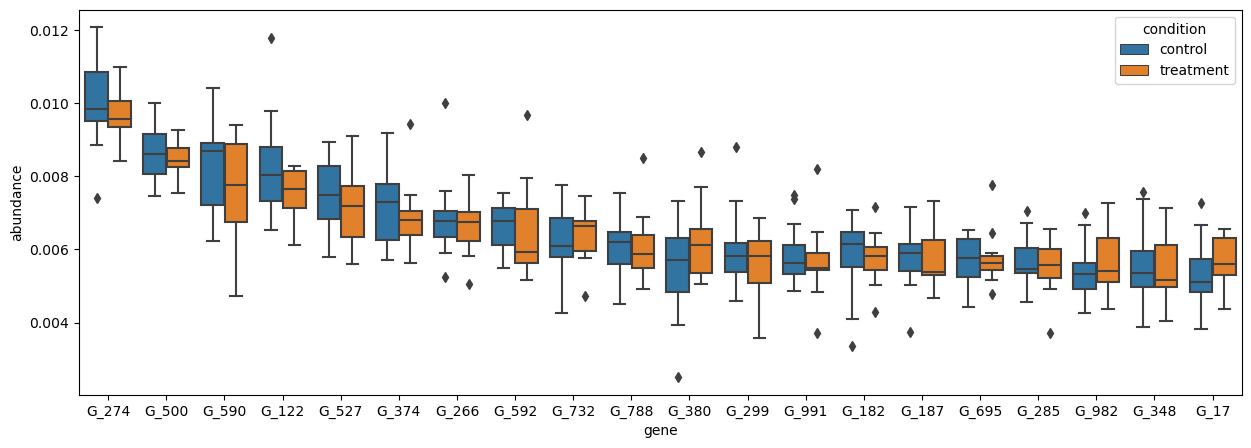

In [9]:
"Distribution of highly abundant genes"
order = gene_stacked.groupby('gene').abundance.mean().sort_values(ascending=False).index[:20]
# or with: gene_df.div(gene_df.sum()).mean(1).sort_values(ascending=False).index

plt.figure(figsize=(15, 5))
sns.boxplot(x='gene', y='abundance', hue='condition', order=order, data=gene_stacked)
plt.show()

# Problem 4: Differential abundance of one gene
Notice that the most abundant genes are not necessarily **differentially abundant** let's use hypothesis testing to see if any genes are though. Since we don't know the effect of our treatment on each gene (it could raise *or* lower expression), let's use a two-tailed test (testing that control and treatment just have different levels of expression, without any hypothesis that one is greater than the other). Assuming we don't have any strong evidence that this data is normally distributed, let's use the non-paramteric [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test).

We want to assess the differential expression between control and treatment for *all* genes, but let's start off by calculating differential expression for one gene, `G_918`.

**Tasks:**
1. Subset `gene_stacked` to where `gene` is `G_918`
2. Plot kernel density estimate plots for the `abundance` colored by `condition`.
3. Calculate the Mann-Whitney (`sps.mannwhitneyu()`) p-value for these two distrubtions and set this as the title.

In [ ]:
"Mann-Whitney for G_918"
# Subset to G_918
g918_df = None

# To calculate the p-value with Mann-Whitney, we need the two lists we are testing
g918_control_abundance = None
g918_treatment_abundance = None

# Calculate the Mann-Whitney p-value
p = None

# Visualize distributions as kde plots and set title as p-value

plt.show()

# Answer

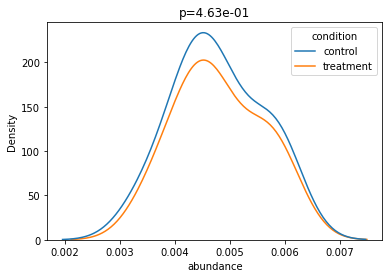

In [ ]:
"Example of computing Mann-Whitney on one gene"
gene = 'G_918'
g918_df = gene_stacked[gene_stacked.gene.eq('G_918')]

# Calculate p-value
a = g918_df[g918_df.condition.eq('control')].abundance
b = g918_df[g918_df.condition.eq('treatment')].abundance
p = sps.mannwhitneyu(a, b).pvalue # Calculate the Mann-Whitney p-value

# Visualize distribution
sns.kdeplot(x='abundance', hue='condition', data=g918_df)
plt.title(f'p={p:.2e}')
plt.show()

# Problem 5: Differential abundance on all genes
Clearly, `G_918` is not affected by this treatment. Let's perform this differential expression test on *all* genes to figure out which ones may be affected by the treatment. Since we want to perform a function on all *groups* of `gene`s, this is the **perfect** opportunity to use pandas' `groupby()` function!

**Task**:
1. Using `gene_stacked.groupby('gene').apply()`, calculate the Mann-Whitney p-value for each gene
2. Remake the boxplot figure from Problem 3, but with the top 25 most differentially expressed genes in order of significance.

In [ ]:
"Calculate differential expression for each gene"
# Hint: look at how we calculated differential expression for one gene above. How can we apply this function to each gene?
de_ps = gene_stacked.groupby('gene').apply(CALCULATE DIFFERENTIAL EXPRESSION FOR THIS GENE HERE)

"Visualize top 25 most differentially expressed genes"
# Order for our boxplots from most to least significant for the top 25 most differentially expressed genes
order = None

plt.show()

# Answer

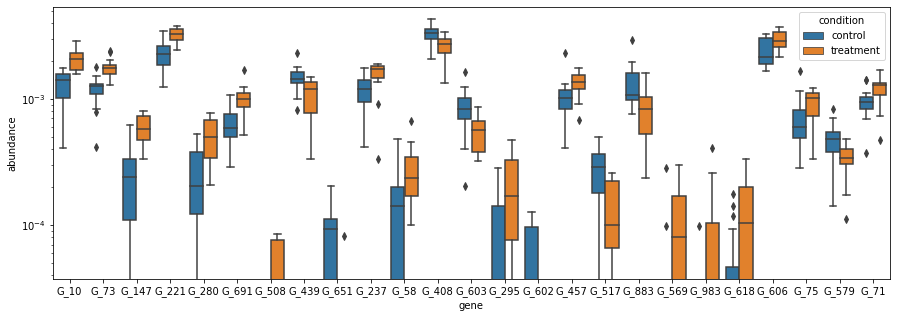

In [ ]:
"Calculate differential expression for each gene"
de_ps = gene_stacked.groupby('gene').apply(lambda x: sps.mannwhitneyu(
                                                              x[x.condition.eq('control')].abundance, 
                                                              x[x.condition.eq('treatment')].abundance)[1])

"Visualize"
order = de_ps.sort_values().index[:25]

plt.figure(figsize=(15, 5))
sns.boxplot(x='gene', y='abundance', hue='condition', order=order, data=gene_stacked)
plt.yscale('log')
plt.show()